In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Pretty print
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [2]:
# import stuff and define basic functions

import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2


# class created by me to handle Waymo dataset

class myFrames:
    def __init__(self):
        self.images = []
        self.camera_calibrations = []

# basic horizontal image flip


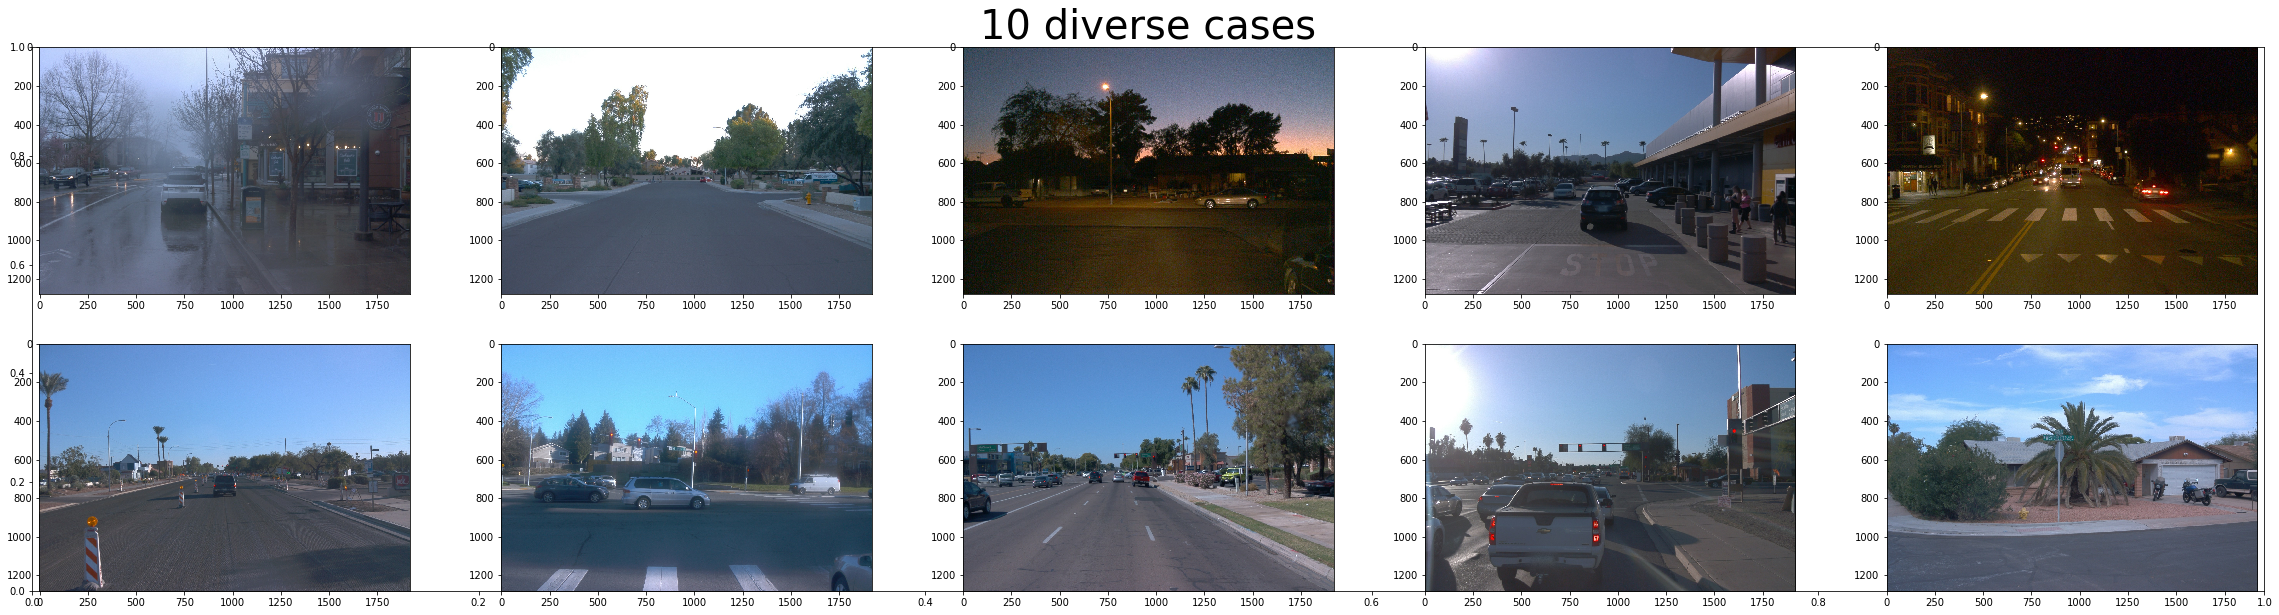

In [3]:
FOLDNAME_LOAD = "../WAYMO-OD2/waymo_to_jon_2"
dataset = myFrames()

fig=plt.figure(figsize=(40, 10))
plt.title("10 diverse cases", fontsize=40)


for frame in range(10):
    images = []
    ### load images
    img_front = Image.open('{}/image_{}/{:06d}.png'.format(FOLDNAME_LOAD, 'front', frame))
    images.append(np.array(img_front)[:,:,:3])
    img_front_left = Image.open('{}/image_{}/{:06d}.png'.format(FOLDNAME_LOAD, 'front_left', frame))
    images.append(np.array(img_front_left)[:,:,:3])
    img_front_right = Image.open('{}/image_{}/{:06d}.png'.format(FOLDNAME_LOAD, 'front_right', frame))
    images.append(np.array(img_front_right)[:,:,:3])
    img_side_left = Image.open('{}/image_{}/{:06d}.png'.format(FOLDNAME_LOAD, 'side_left', frame))
    images.append(np.array(img_side_left)[:,:,:3])
    img_side_right = Image.open('{}/image_{}/{:06d}.png'.format(FOLDNAME_LOAD, 'side_right', frame))
    images.append(np.array(img_side_right)[:,:,:3])
    dataset.images.append(images)

    
    fig.add_subplot(2, 5, frame+1)
    plt.imshow(np.array(img_front))

    
    ### load intrinsics and extrinsics

    calib_params = np.load('{}/calib/{:06d}.npy'.format(FOLDNAME_LOAD, frame), allow_pickle=True)

    camera_names =['front','front_left', 'front_right', 'side_left' , 'side_right']
    dataset.camera_calibrations.append({})
    for i in range(5):
        intr = calib_params.item().get('camera_{}_intrinsics'.format(camera_names[i]))[0]
        extr = calib_params.item().get('camera_{}_extrinsics'.format(camera_names[i]))
        dataset.camera_calibrations[frame][i] = [intr, extr]


plt.show()
    

# Select case

In [4]:
frame_id = 8 # 0 to 9, ten frames

# 5 item lists containing images, intrinsics and extrinsics of each of the 5 cameras at the current frame

images = dataset.images[frame_id]
intrinsics_all5 = [dataset.camera_calibrations[frame_id][e][0] for e in dataset.camera_calibrations[frame_id]]
extrinsics_all5 = [dataset.camera_calibrations[frame_id][e][1] for e in dataset.camera_calibrations[frame_id]]

# Process

In [6]:

h_ = 1280
w_ = 1920

t = np.hstack([np.zeros((h_, 5*w_, 3)).astype('uint8')])

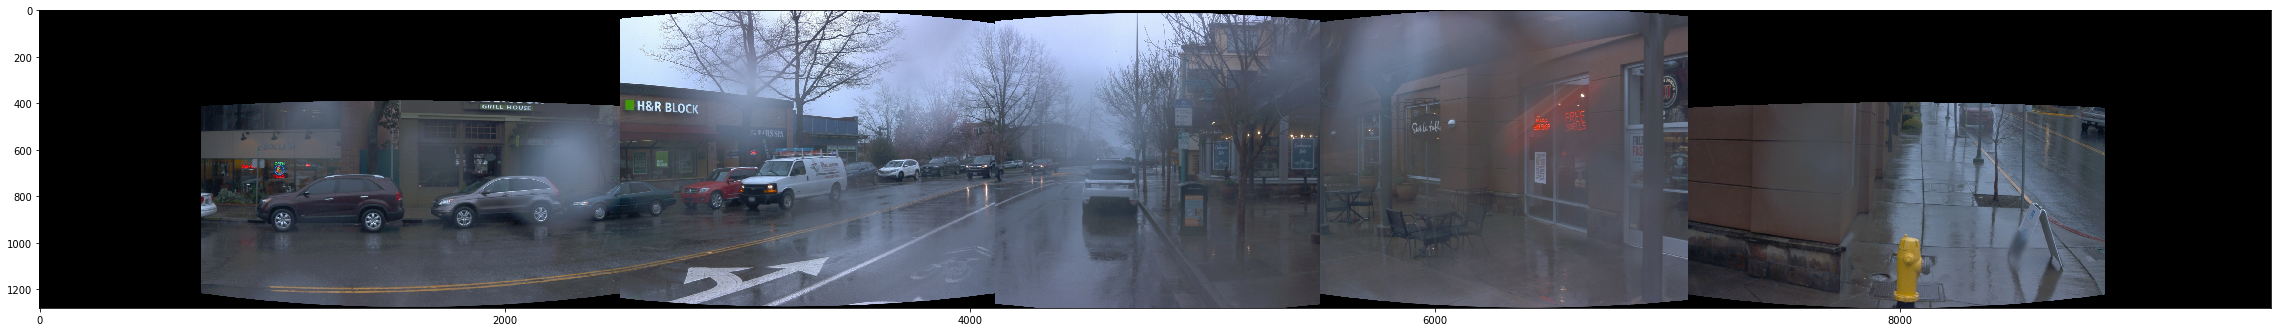

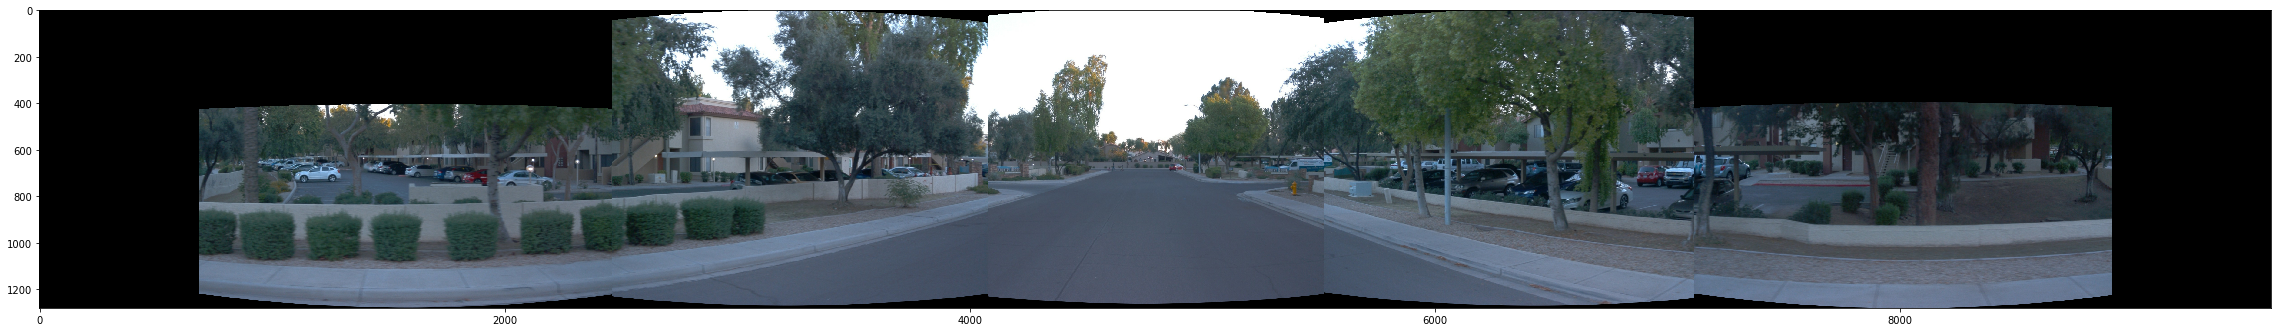

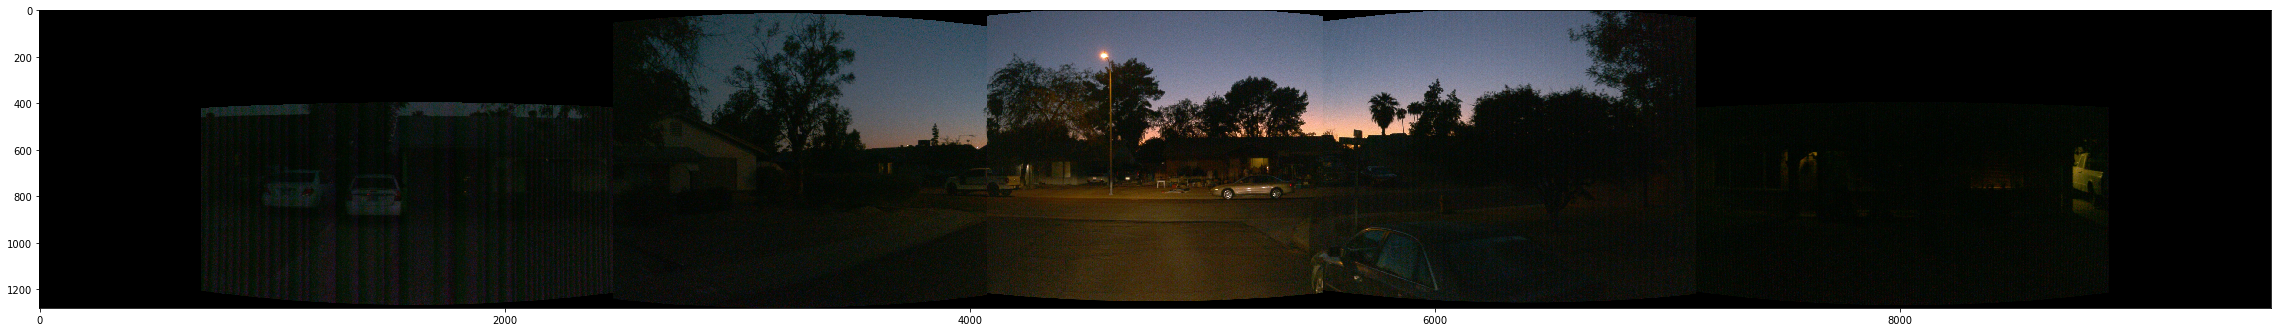

In [ ]:
for frame_id in range(10):
    
    #frame_id = 8 # 0 to 9, ten frames

    # 5 item lists containing images, intrinsics and extrinsics of each of the 5 cameras at the current frame

    images = dataset.images[frame_id]
    intrinsics_all5 = [dataset.camera_calibrations[frame_id][e][0] for e in dataset.camera_calibrations[frame_id]]
    extrinsics_all5 = [dataset.camera_calibrations[frame_id][e][1] for e in dataset.camera_calibrations[frame_id]]

    t = np.hstack([np.zeros((h_, 5*w_, 3)).astype('uint8')])
    for camera_id in range(1,6):
        # select camera

        #camera_id = 4
        #    FRONT = 1;
        #    FRONT_LEFT = 2;
        #    FRONT_RIGHT = 3;
        #    SIDE_LEFT = 4;
        #    SIDE_RIGHT = 5;

        img = images[camera_id - 1]

        # Camera Extrinsics Matrix 4x4
        E = extrinsics_all5[camera_id - 1]

        intrinsics = intrinsics_all5[camera_id - 1]

        # Camera Intrinsics Matrix 3x3
        K = np.array([[intrinsics[0],0,intrinsics[2]],[0,intrinsics[1],intrinsics[3]],[0,0,1]])

        # Rotation matrix
        R = E[:-1, :-1]

        # Undistort
        img = cv2.undistort(img, K, np.array(intrinsics[4:]))

        # CylindricalWarp


        #     We want destination images from the cameras to have similar properties,
        #     so for reprojection we use the same Intrinsics matrix

        K_central = [[2060, 0, w_/2.], [0,2060, h_/2], [0,0,1]]

        y_i, x_i = np.indices((h_, w_))
        dst_pixel_coords = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3)

        Kinv = np.linalg.inv(K_central)

        # The [x,y,z coords of each of the destination pixels

        dst_3d_coords = np.dot(Kinv, dst_pixel_coords.T).T

        # calculate cylindrical coords (sin\theta, h, cos\theta)
        A = np.stack([np.sin(dst_3d_coords[:,0]),dst_3d_coords[:,1],np.cos(dst_3d_coords[:,0])],axis=-1).reshape(w_*h_,3)

        # Find which pixels in the source image will end up at each of the pixels in dst_pixel_coords

        B = K.dot(A.T).T # project back to image-pixels plane

        # back from homog coords
        B = B[:,:-1] / B[:,[-1]]
        # make sure warp coords only within image bounds
        B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
        B = B.reshape(h_,w_,-1)

        IM = cv2.remap(img, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA)


        corner_points = np.array(
            [[   0,    0,    1],
               [w_,    0,    1],
               [   0, h_,    1],
               [w_, h_,    1]])

        p3d = np.dot(np.linalg.inv(K), corner_points.T).T

        p3d_cyl = np.divide(p3d, np.linalg.norm([p3d[:,0],p3d[:,2]], axis=0).reshape((4, 1)))
        cyl_coord_p3d_cyl = [np.arcsin(p3d_cyl[:,0]), p3d_cyl[:,1], np.ones_like(p3d_cyl[:,0])]
        p_dst = np.dot(K_central,np.transpose(cyl_coord_p3d_cyl).T)
        p_dst = np.round(p_dst).astype(int)

        w_min = np.min(p_dst[0])
        w_max = np.max(p_dst[0])
        h_min = np.min(p_dst[1])
        h_max = np.max(p_dst[1])

        #fov_angle
        fov_angle = np.max(np.arcsin(p3d_cyl[:,0])) - np.min(np.arcsin(p3d_cyl[:,0]))

        pixel_per_rad = (w_max - w_min) / fov_angle



        #plt.imshow(IM[h_min:h_max, w_min: w_max, :])

        IM = IM[:, w_min: w_max, :]

        # Assemble all together

        phase_angle = np.arcsin(R[0][1])
        pixel_phase = round(phase_angle * pixel_per_rad)

        im_center = t.shape[1]//2 + int(pixel_phase)
        t[:,im_center - IM.shape[1]//2: im_center + IM.shape[1]//2, :] = IM[:,:(IM.shape[1]//2)*2, :]
    fig=plt.figure(figsize=(40, 20))
    plt.imshow(t)
    plt.show()
    im = Image.fromarray(t)
    im.save("case_{}.jpeg".format(frame_id))


In [ ]:
intrinsics_all5

In [ ]:
886/2

In [ ]:
images[4].shape

In [61]:
K_central = [[2060, 0, w_/2.], [0,2060, h_/2], [0,0,1]]

In [79]:
ang = np.arcsin(E[:,0][1])
M = np.zeros([3,3])
M[0][0] = np.cos(ang)
M[0][1] = -np.sin(ang)
M[1][1] = np.cos(ang)
M[1][0] = np.sin(ang)
M[2][2] = 1.

In [80]:
M

array([[ 0.00808,  0.99997,  0.     ],
       [-0.99997,  0.00808,  0.     ],
       [ 0.     ,  0.     ,  1.     ]])

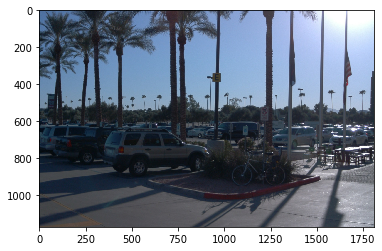

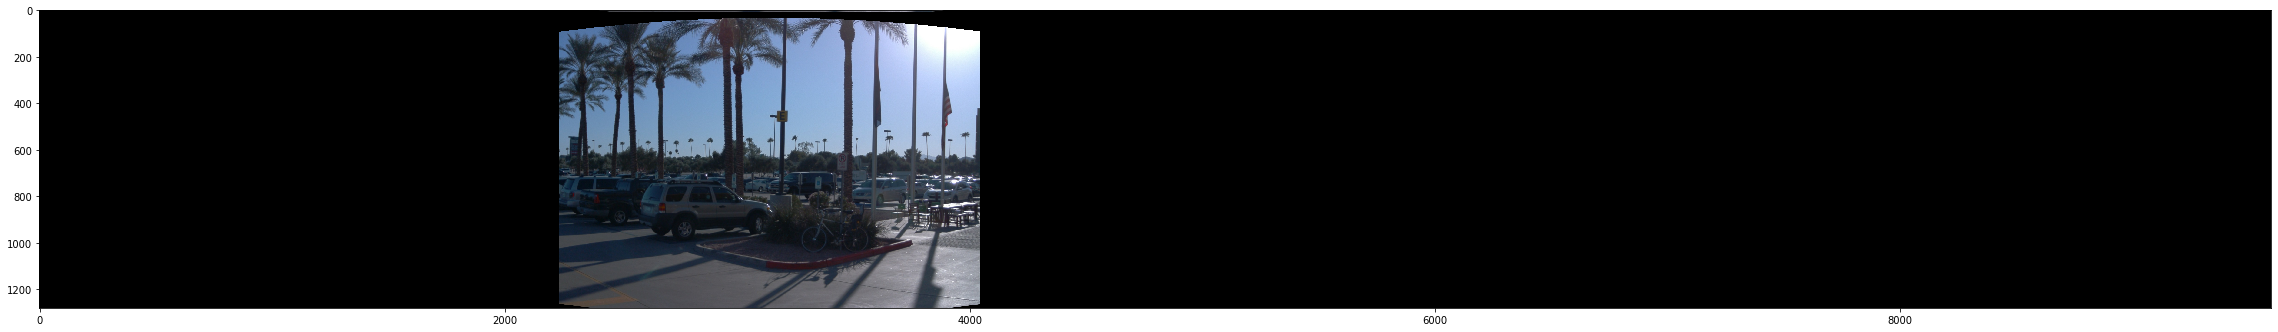

In [43]:


corner_points = np.array(
    [[   0,    0,    1],
       [w_,    0,    1],
       [   0, h_,    1],
       [w_, h_,    1]])

p3d = np.dot(np.linalg.inv(K), corner_points.T).T

p3d_cyl = np.divide(p3d, np.linalg.norm([p3d[:,0],p3d[:,2]], axis=0).reshape((4, 1)))
cyl_coord_p3d_cyl = [np.arcsin(p3d_cyl[:,0]), p3d_cyl[:,1], np.ones_like(p3d_cyl[:,0])]
p_dst = np.dot(K_central,np.transpose(cyl_coord_p3d_cyl).T)
p_dst = np.round(p_dst).astype(int)

w_min = np.min(p_dst[0])
w_max = np.max(p_dst[0])
h_min = np.min(p_dst[1])
h_max = np.max(p_dst[1])

#fov_angle
fov_angle = np.max(np.arcsin(p3d_cyl[:,0])) - np.min(np.arcsin(p3d_cyl[:,0]))

pixel_per_rad = (w_max - w_min) / fov_angle



plt.imshow(IM[h_min:h_max, w_min: w_max, :])
IM = IM[:, w_min: w_max, :]

# Assemble all together

phase_angle = np.arcsin(R[0][1])
pixel_phase = round(phase_angle * pixel_per_rad)

im_center = t.shape[1]//2 + int(pixel_phase)
t[:,im_center - IM.shape[1]//2: im_center + IM.shape[1]//2, :] = IM[:,:(IM.shape[1]//2)*2, :]
fig=plt.figure(figsize=(40, 20))
plt.imshow(t)


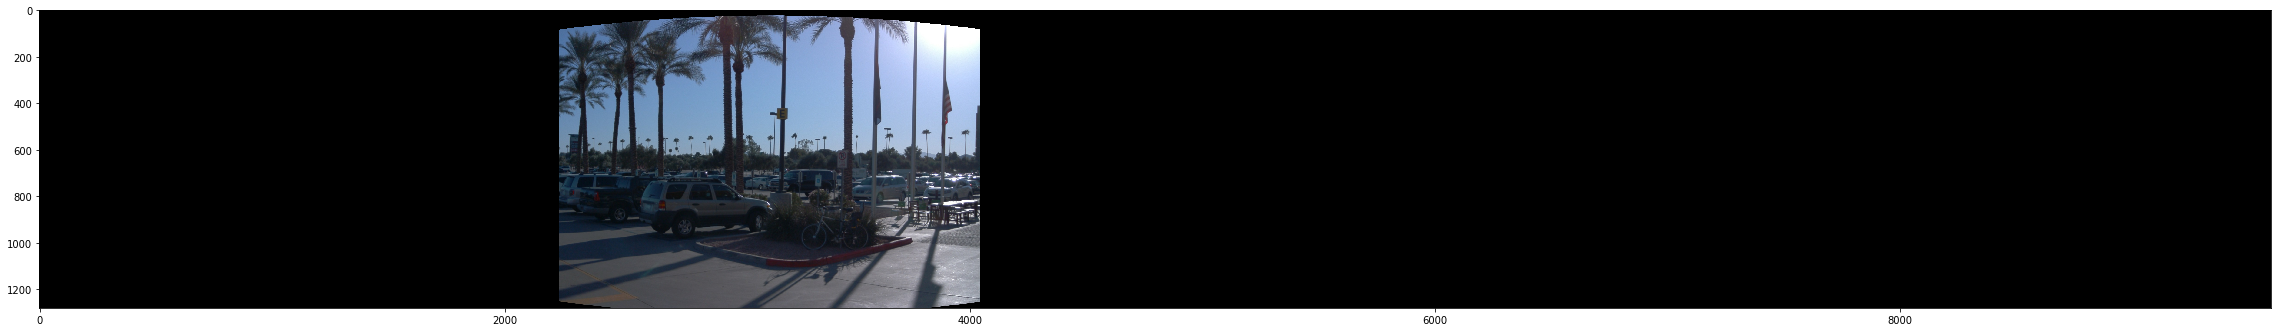

In [45]:
t = np.hstack([np.zeros((h_, 5*w_, 3)).astype('uint8')])
phase_angle = np.arcsin(R[0][1])
pixel_phase = round(phase_angle * pixel_per_rad)

im_center = t.shape[1]//2 + int(pixel_phase)
t[:,im_center - IM.shape[1]//2: im_center + IM.shape[1]//2, :] = IM[:,:(IM.shape[1]//2)*2, :]
fig=plt.figure(figsize=(40, 20))
plt.imshow(t)

In [40]:




h_ = 1280
w_ = 1920


# We want destination images from the cameras to have similar properties,
# so for reprojection we use the same Intrinsics matrix

intrinsics_central = myframes.camera_calibrations[1][0]
K_central = np.array([[intrinsics_central[0],0,intrinsics_central[2]],[0,intrinsics_central[1],intrinsics_central[3]],[0,0,1]])



y_i, x_i = np.indices((h_, w_))
dst_pixel_coords = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3)

Kinv = np.linalg.inv(K_central)

# The [x,y,z coords of each of the destination pixels

dst_3d_coords = np.dot(Kinv, dst_pixel_coords.T).T

# calculate cylindrical coords (sin\theta, h, cos\theta)
A = np.stack([np.sin(dst_3d_coords[:,0]),dst_3d_coords[:,1],np.cos(dst_3d_coords[:,0])],axis=-1).reshape(w_*h_,3)

# Find which pixels in the source image will end up at each of the pixels in dst_pixel_coords

B = K.dot(A.T).T # project back to image-pixels plane

# back from homog coords
B = B[:,:-1] / B[:,[-1]]
# make sure warp coords only within image bounds
B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
B = B.reshape(h_,w_,-1)


fig=plt.figure(figsize=(40, 20))


IM = cv2.remap(img, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA)


p3d = np.dot(np.linalg.inv(K), corner_points.T).T

p3d_cyl = np.divide(p3d, np.linalg.norm([p3d[:,0],p3d[:,2]], axis=0).reshape((4, 1)))
cyl_coord_p3d_cyl = [np.arcsin(p3d_cyl[:,0]), p3d_cyl[:,1], np.ones_like(p3d_cyl[:,0])]
p_dst = np.dot(K_central,np.transpose(cyl_coord_p3d_cyl).T)
p_dst = np.round(p_dst).astype(int)

w_min = np.min(p_dst[0])
w_max = np.max(p_dst[0])
h_min = np.min(p_dst[1])
h_max = np.max(p_dst[1])

#fov_angle
fov_angle = np.max(np.arcsin(p3d_cyl[:,0])) - np.min(np.arcsin(p3d_cyl[:,0]))

pixel_per_rad = (w_max - w_min) / fov_angle



plt.imshow(IM[h_min:h_max, w_min: w_max, :])
IM = IM[:, w_min: w_max, :]

NameError: name 'myframes' is not defined

In [ ]:
right = True
down = False



i = img.shape[0]*down

j = img.shape[1]*right

p = [j,i,1]

corner_points = []
for down in [0,1]:
    for right in [0,1]:
        
        i = img.shape[0]*down
        j = img.shape[1]*right
        p = np.array([j,i,1])
        corner_points.append(p)
corner_points = np.array(corner_points)

In [ ]:
corner_points = np.array(
    [[   0,    0,    1],
       [w_,    0,    1],
       [   0, h_,    1],
       [w_, h_,    1]])

In [ ]:
images[0][:,:,:3]